In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashion-product-images-small/styles.csv
/kaggle/input/fashion-product-images-small/myntradataset/styles.csv
/kaggle/input/fashion-product-images-small/myntradataset/images/31973.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/30778.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/19812.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/22735.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/38246.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/16916.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/52876.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/39500.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/44758.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/59454.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/44951.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/

In [2]:
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar
import random
import requests
from io import BytesIO

In [3]:
# Parameters
data_dir = '/kaggle/input/fashion-product-images-small/images'
img_size = 128

In [4]:
df = pd.read_csv("/kaggle/input/fashion-product-images-small/styles.csv", on_bad_lines='skip')
df = df[:10000]
df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [5]:
# Assuming 'data_dir' and 'img_size' are defined earlier
list_of_data = []
total_processed = 0
total_skipped = 0

# Use tqdm to wrap around df.iterrows() for progress tracking
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Images"):
    img_path = os.path.join(data_dir, str(row['id']) + ".jpg")

    # Check if the image file exists before trying to read it
    if not os.path.exists(img_path):
        print(f"Warning: Image file not found at path: {img_path}")
        total_skipped += 1  # Increment skipped counter for missing file
        continue  # Skip to the next iteration if the image is not found

    # Check for missing class labels
    if any(row.get(key) is None for key in ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']):
        print(f"Skipping image due to missing class labels for ID: {row['id']}")
        total_skipped += 1  # Increment skipped counter for missing class labels
        continue  # Skip to the next iteration if any class label is missing

    img_arr = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshape images to preferred size

    json_dict = {
        'image': resized_arr.tolist(),  # Convert NumPy array to list for JSON serialization
        'class_1': row['gender'],
        'class_2': row['masterCategory'],
        'class_3': row['subCategory'],
        'class_4': row['articleType'],
        'class_5': row['baseColour'],
        'class_6': row['season'],
        'class_7': row['usage']
    }

    # Append the json_dict to the list
    list_of_data.append(json_dict)
    total_processed += 1  # Increment processed counter

# Print the summary
print(f"Total images processed: {total_processed}")
print(f"Total images skipped: {total_skipped}")

Processing Images:  67%|██████▋   | 6706/10000 [02:11<00:39, 83.81it/s]

Processing Images: 100%|██████████| 10000/10000 [03:20<00:00, 49.97it/s]

Total images processed: 9999
Total images skipped: 1


In [6]:
# Splitting into x_train and y_train
x_train = []
y_train = []

for data in list_of_data:
    x_train.append(data['image'])
    y_train.append([data['class_1'], data['class_2'], data['class_3'], data['class_4'], data['class_5'], data['class_6'], data['class_7']])

x_train = np.array(x_train) / 255
x_train = x_train.reshape(x_train.shape[0], img_size, img_size, 3)

In [7]:
# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(x_train)

In [8]:
y_train = np.array(y_train)

# Initialize lists to store mappings and class arrays
class_maps = {}
class_arrays = []
num_classes = 7  # Update this if you have more or fewer classes

# Loop through each class
for i in range(num_classes):
    class_data = y_train[:, i]  # Get data for the current class
    class_map = {j: idx for idx, j in enumerate(set(class_data))}
    class_arr = np.array([class_map[x] for x in class_data])
    
    class_maps[f'map_{i + 1}'] = class_map  # Store the mapping
    class_arrays.append(class_arr)  # Append the class array to the list

# Convert class_arrays list to a 2D NumPy array if needed
class_arrays = np.array(class_arrays).T  # Transpose to get the correct shape
# Assuming you have already determined the number of classes for each task
c_1 = len(class_maps['map_1'])  # Number of classes for gender
c_2 = len(class_maps['map_2'])  # Number of classes for master category
c_3 = len(class_maps['map_3'])  # Number of classes for sub-category
c_4 = len(class_maps['map_4'])  # Number of classes for article type
c_5 = len(class_maps['map_5'])  # Number of classes for base color
c_6 = len(class_maps['map_6'])  # Number of classes for season
c_7 = len(class_maps['map_7'])  # Number of classes for usage
class_arr_gender = class_arrays[:, 0]  # Adjust the index based on your arrangement
class_arr_master_category = class_arrays[:, 1]
class_arr_sub_category = class_arrays[:, 2]
class_arr_article_type = class_arrays[:, 3]
class_arr_base_colour = class_arrays[:, 4]
class_arr_season = class_arrays[:, 5]
class_arr_usage = class_arrays[:, 6]

## Gender

In [11]:
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Load VGG16 as the base model
base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3),
                                          include_top=False,
                                          weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Add VGG layers
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)  # Flatten the output of the base model
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a dense layer after the base model

# Output branches for multitask classification
gender_branch = tf.keras.layers.Dense(c_1, activation='softmax', name='gender_output')(x)
# master_category_branch = tf.keras.layers.Dense(c_2, activation='softmax', name='masterCategory_output')(x)
# sub_category_branch = tf.keras.layers.Dense(c_3, activation='softmax', name='subCategory_output')(x)
# article_type_branch = tf.keras.layers.Dense(c_4, activation='softmax', name='articleType_output')(x)
# base_colour_branch = tf.keras.layers.Dense(c_5, activation='softmax', name='baseColour_output')(x)
# season_branch = tf.keras.layers.Dense(c_6, activation='softmax', name='season_output')(x)
# usage_branch = tf.keras.layers.Dense(c_7, activation='softmax', name='usage_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[
    gender_branch,
#     master_category_branch,
#     sub_category_branch,
#     article_type_branch,
#     base_colour_branch,
#     season_branch,
#     usage_branch
])

# Summary of the model to check the architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender_output (Dense)           │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,912,069 (72.14 MB)

 Trainable params: 4,197,381 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [13]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'gender_output': class_arr_gender,  # Assuming you have a corresponding class array
#         'masterCategory_output': class_arr_master_category,
#         'subCategory_output': class_arr_sub_category,
#         'articleType_output': class_arr_article_type,
#         'baseColour_output': class_arr_base_colour,
#         'season_output': class_arr_season,
#         'usage_output': class_arr_usage
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10


I0000 00:00:1729943765.374297     248 service.cc:145] XLA service 0x7c878000a540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729943765.374366     248 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729943765.374376     248 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/125 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.3359 - loss: 7.9983  

I0000 00:00:1729943777.695872     248 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 218ms/step - accuracy: 0.6228 - loss: 2.4491 - val_accuracy: 0.4885 - val_loss: 1.2905
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.7915 - loss: 0.5571 - val_accuracy: 0.8465 - val_loss: 0.4374
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.8453 - loss: 0.4064 - val_accuracy: 0.7180 - val_loss: 0.6499
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.8602 - loss: 0.3644 - val_accuracy: 0.8695 - val_loss: 0.3777
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.8817 - loss: 0.3171 - val_accuracy: 0.8600 - val_loss: 0.3914
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.8892 - loss: 0.2975 - val_accuracy: 0.8715 - val_loss: 0.3735
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.9078 - loss: 0.2582 - val_accuracy: 0.8540 - val_loss: 0.4095
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9172 - loss: 0.2274 - val_accura

In [14]:
# Convert the history object to a DataFrame
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv('training_history.csv', index=False)

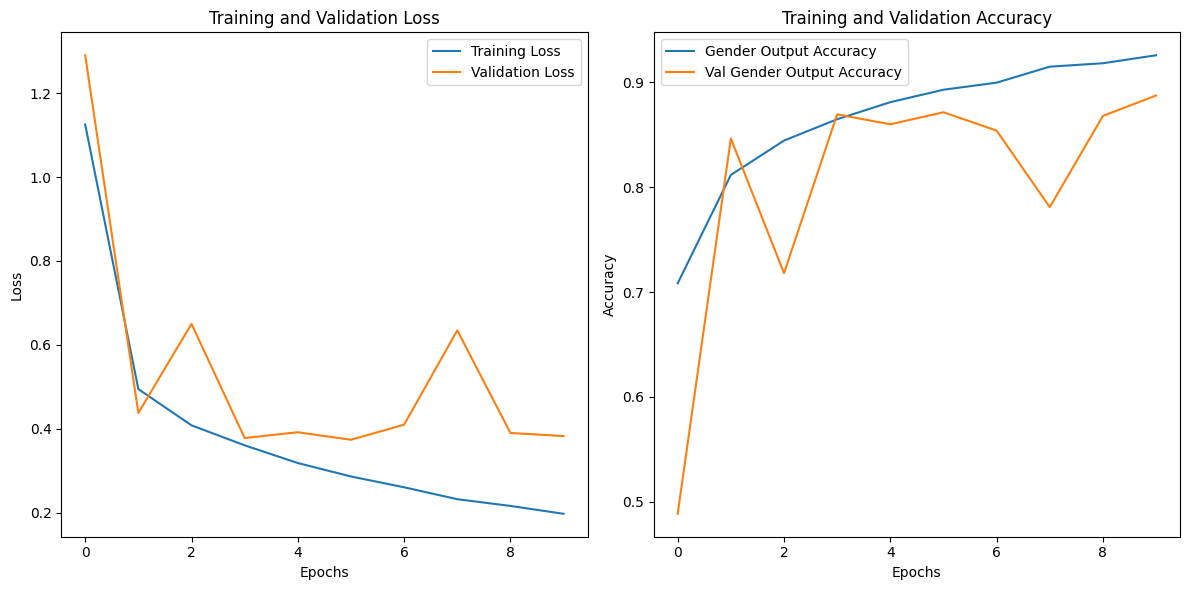

In [19]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Gender Output Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Gender Output Accuracy')

# plt.plot(history.history['masterCategory_output_accuracy'], label='Master Category Accuracy')
# plt.plot(history.history['val_masterCategory_output_accuracy'], label='Val Master Category Accuracy')

# plt.plot(history.history['subCategory_output_accuracy'], label='Sub Category Accuracy')
# plt.plot(history.history['val_subCategory_output_accuracy'], label='Val Sub Category Accuracy')

# plt.plot(history.history['articleType_output_accuracy'], label='Article Type Accuracy')
# plt.plot(history.history['val_articleType_output_accuracy'], label='Val Article Type Accuracy')

# plt.plot(history.history['baseColour_output_accuracy'], label='Base Colour Accuracy')
# plt.plot(history.history['val_baseColour_output_accuracy'], label='Val Base Colour Accuracy')

# plt.plot(history.history['season_output_accuracy'], label='Season Accuracy')
# plt.plot(history.history['val_season_output_accuracy'], label='Val Season Accuracy')

# plt.plot(history.history['usage_output_accuracy'], label='Usage Accuracy')
# plt.plot(history.history['val_usage_output_accuracy'], label='Val Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

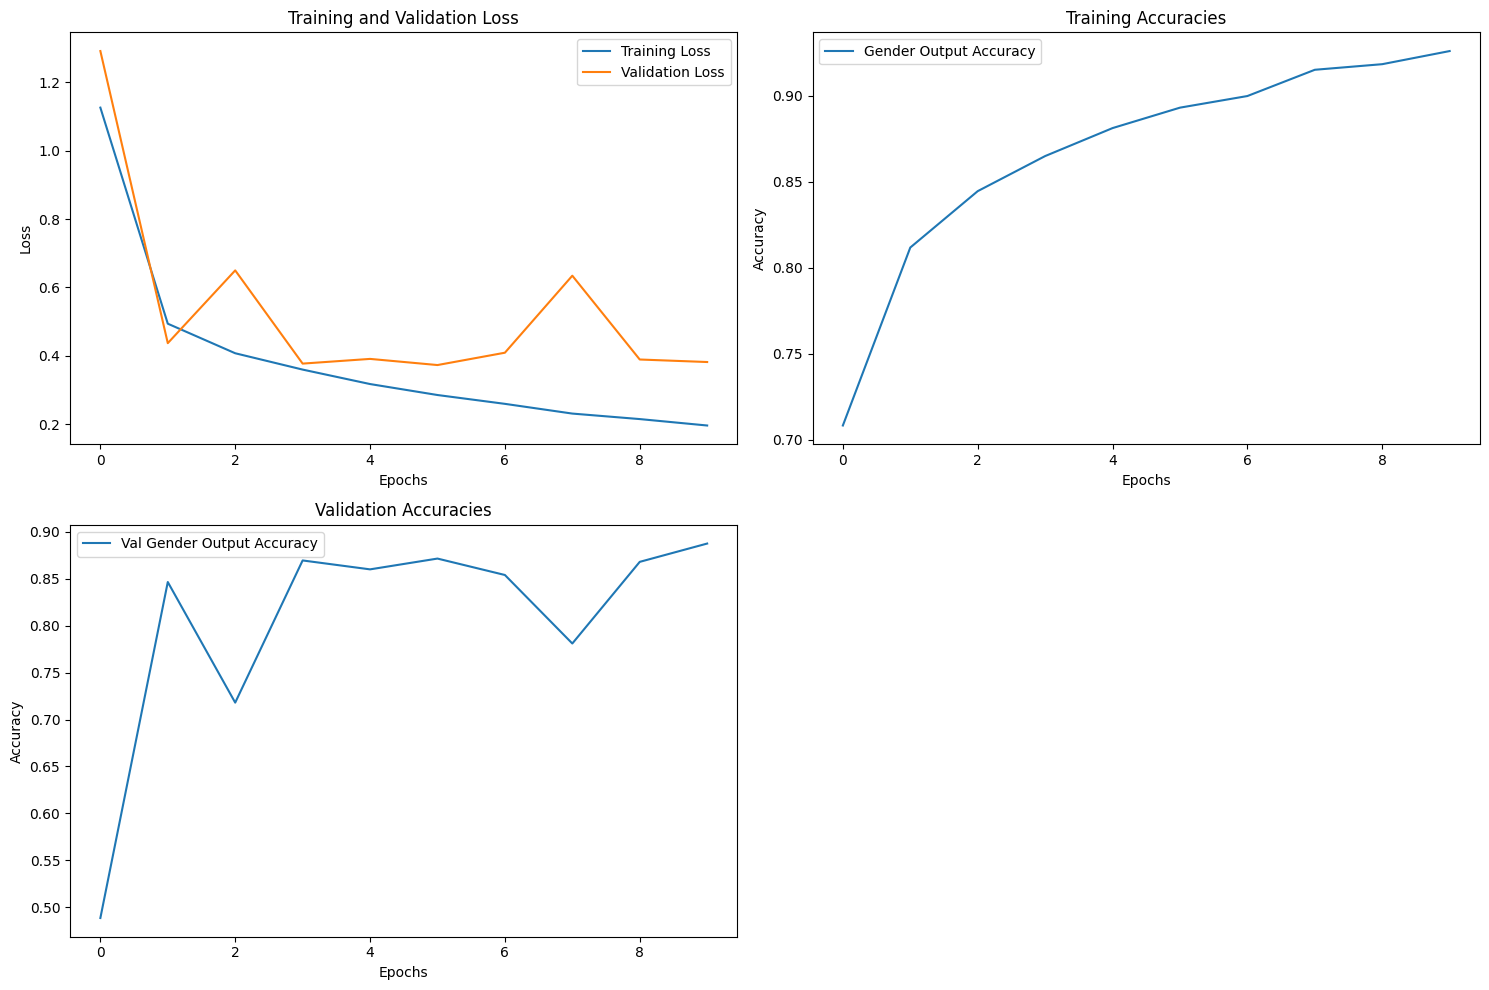

In [20]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Gender Output Accuracy')
# plt.plot(history.history['masterCategory_output_accuracy'], label='Master Category Accuracy')
# plt.plot(history.history['subCategory_output_accuracy'], label='Sub Category Accuracy')
# plt.plot(history.history['articleType_output_accuracy'], label='Article Type Accuracy')
# plt.plot(history.history['baseColour_output_accuracy'], label='Base Colour Accuracy')
# plt.plot(history.history['season_output_accuracy'], label='Season Accuracy')
# plt.plot(history.history['usage_output_accuracy'], label='Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Gender Output Accuracy')
# plt.plot(history.history['val_masterCategory_output_accuracy'], label='Val Master Category Accuracy')
# plt.plot(history.history['val_subCategory_output_accuracy'], label='Val Sub Category Accuracy')
# plt.plot(history.history['val_articleType_output_accuracy'], label='Val Article Type Accuracy')
# plt.plot(history.history['val_baseColour_output_accuracy'], label='Val Base Colour Accuracy')
# plt.plot(history.history['val_season_output_accuracy'], label='Val Season Accuracy')
# plt.plot(history.history['val_usage_output_accuracy'], label='Val Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## masterCategory

In [21]:
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Load VGG16 as the base model
base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3),
                                          include_top=False,
                                          weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Add VGG layers
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)  # Flatten the output of the base model
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a dense layer after the base model

# Output branches for multitask classification
master_category_branch = tf.keras.layers.Dense(c_2, activation='softmax', name='masterCategory_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[
    master_category_branch
])

# Summary of the model to check the architecture
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masterCategory_output (Dense)   │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,912,582 (72.15 MB)

 Trainable params: 4,197,894 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [23]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'masterCategory_output': class_arr_master_category
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.8102 - loss: 1.4142 - val_accuracy: 0.9600 - val_loss: 0.1457
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.9523 - loss: 0.1408 - val_accuracy: 0.9720 - val_loss: 0.0898
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.9721 - loss: 0.0936 - val_accuracy: 0.9650 - val_loss: 0.1383
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9712 - loss: 0.0802 - val_accuracy: 0.9745 - val_loss: 0.0829
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.9812 - loss: 0.0575 - val_accuracy: 0.9715 - val_loss: 0.0920
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9871 - loss: 0.0394 - val_accuracy: 0.9540 - val_loss: 0.1582
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9860 - loss: 0.0391 - val_accuracy: 0.9810 - val_loss: 0.0739
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9893 - loss: 0.03

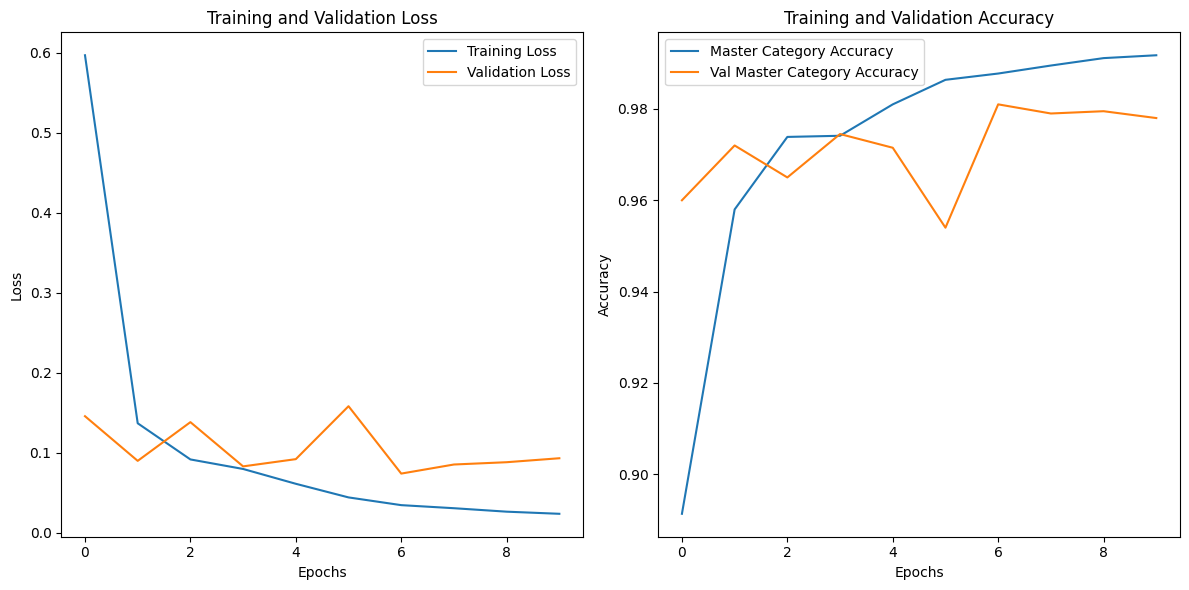

In [25]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], label='Master Category Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Master Category Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

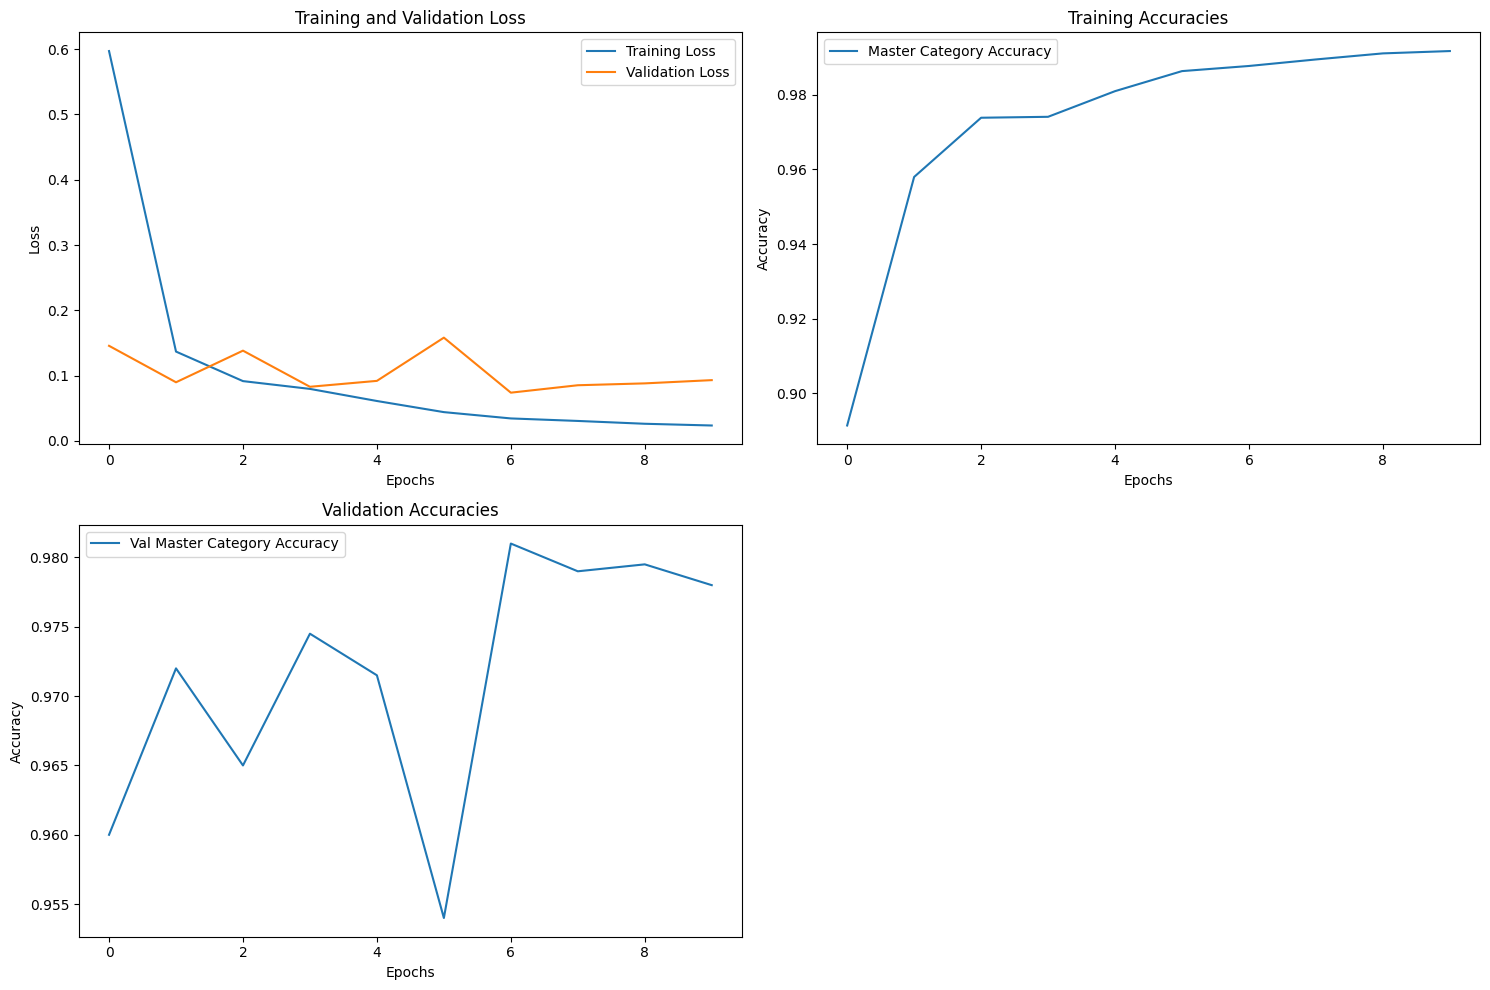

In [26]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Master Category Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Master Category Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## sub_category

In [27]:
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Load VGG16 as the base model
base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3),
                                          include_top=False,
                                          weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Add VGG layers
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)  # Flatten the output of the base model
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a dense layer after the base model

# Output branches for multitask classification
sub_category_branch = tf.keras.layers.Dense(c_3, activation='softmax', name='subCategory_output')(x)


# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[
    sub_category_branch
])

# Summary of the model to check the architecture
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subCategory_output (Dense)      │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,930,024 (72.21 MB)

 Trainable params: 4,215,336 (16.08 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [29]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'subCategory_output': class_arr_sub_category
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6786 - loss: 1.9929 - val_accuracy: 0.8405 - val_loss: 0.6186
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.8816 - loss: 0.4065 - val_accuracy: 0.8955 - val_loss: 0.3870
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9177 - loss: 0.2837 - val_accuracy: 0.9135 - val_loss: 0.3214
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9403 - loss: 0.2030 - val_accuracy: 0.8905 - val_loss: 0.4179
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9456 - loss: 0.1685 - val_accuracy: 0.9095 - val_loss: 0.3818
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9524 - loss: 0.1393 - val_accuracy: 0.9135 - val_loss: 0.3183
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9625 - loss: 0.1139 - val_accuracy: 0.9130 - val_loss: 0.3666
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9708 - loss: 0.08

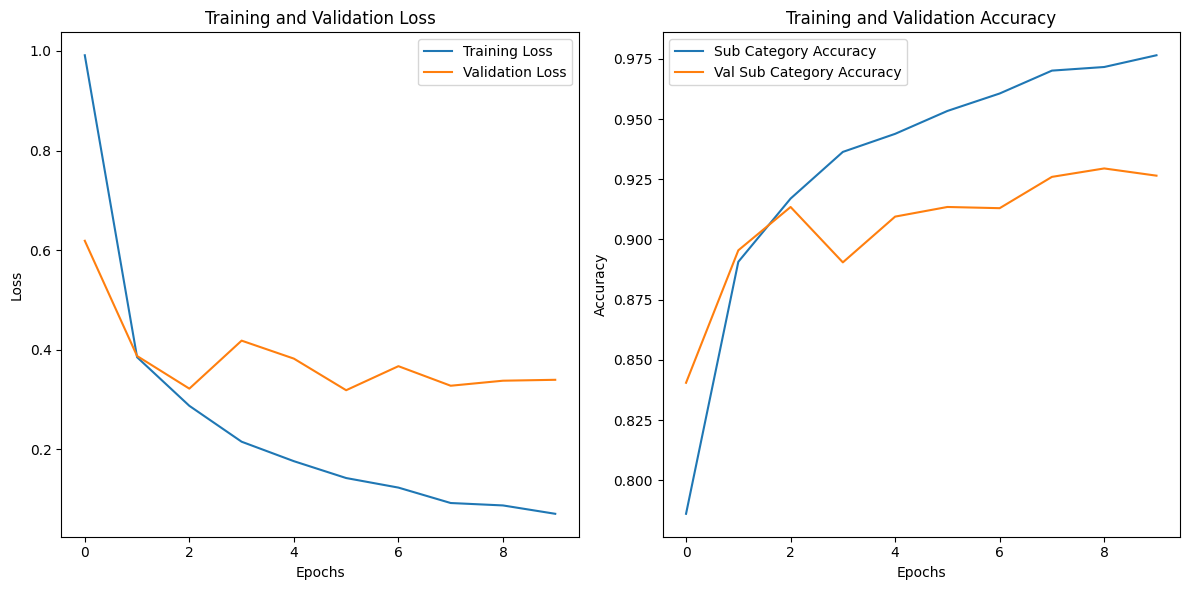

In [30]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)


plt.plot(history.history['accuracy'], label='Sub Category Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Sub Category Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

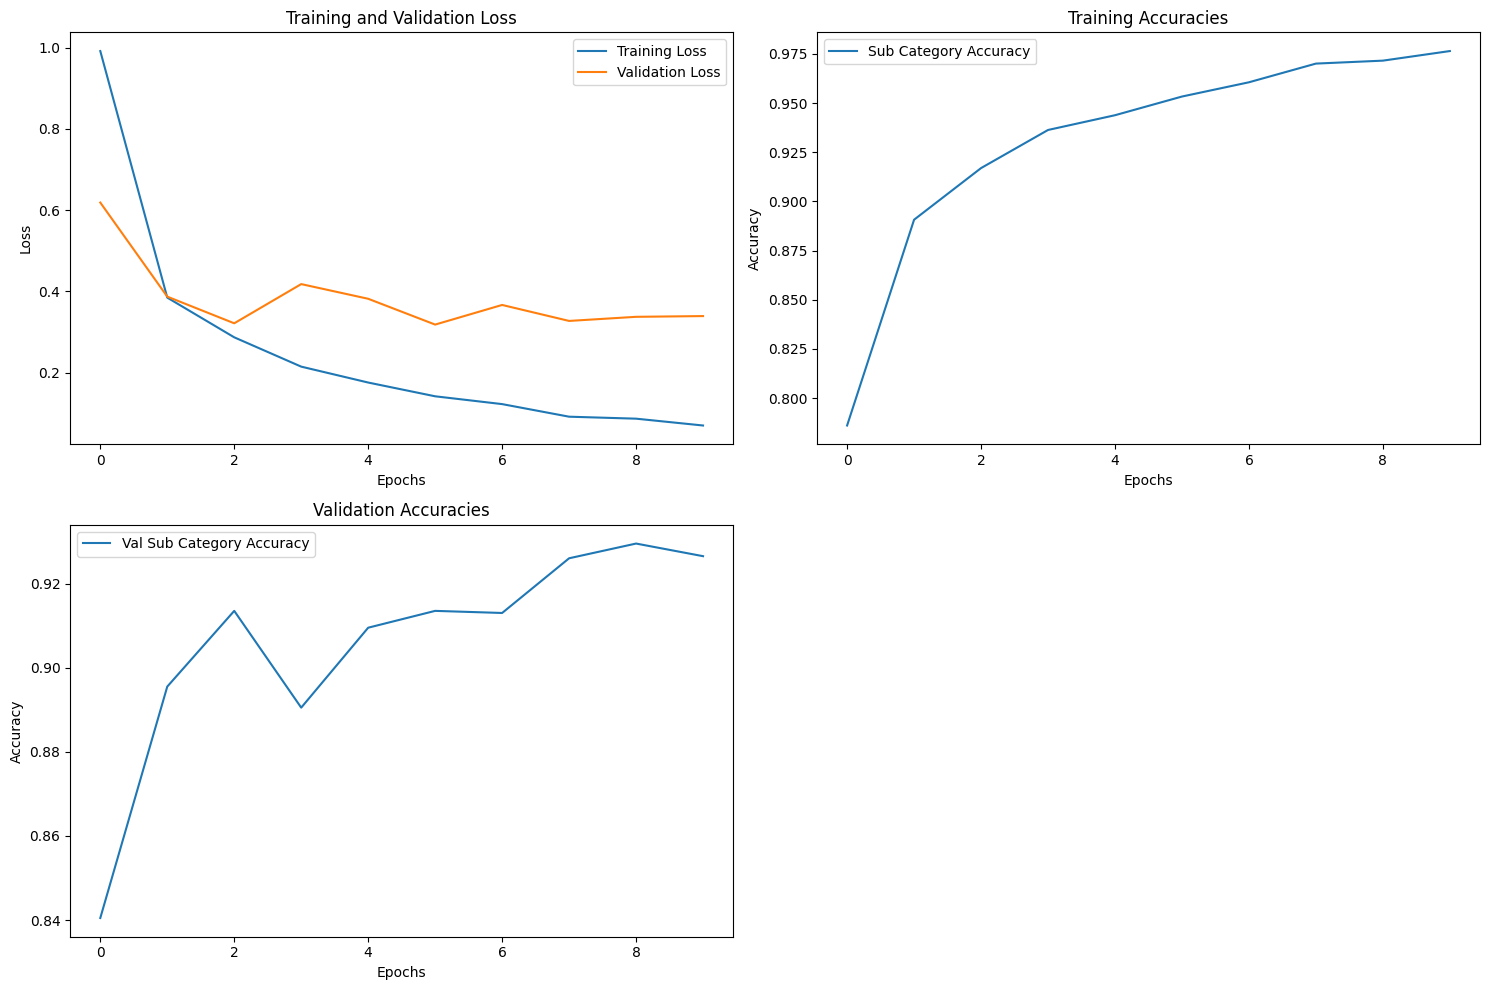

In [32]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Sub Category Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Sub Category Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## article_type

In [33]:
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Load VGG16 as the base model
base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3),
                                          include_top=False,
                                          weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Add VGG layers
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)  # Flatten the output of the base model
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a dense layer after the base model

# Output branches for multitask classification
article_type_branch = tf.keras.layers.Dense(c_4, activation='softmax', name='articleType_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[
    article_type_branch,
])

# Summary of the model to check the architecture
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ articleType_output (Dense)      │ (None, 127)            │        65,151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,974,655 (72.38 MB)

 Trainable params: 4,259,967 (16.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [35]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'articleType_output': class_arr_article_type

    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.4623 - loss: 3.0843 - val_accuracy: 0.6775 - val_loss: 1.1821
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.7374 - loss: 0.9469 - val_accuracy: 0.7255 - val_loss: 1.0118
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.7896 - loss: 0.6926 - val_accuracy: 0.7435 - val_loss: 0.9150
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.8278 - loss: 0.5453 - val_accuracy: 0.7600 - val_loss: 0.8647
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.8650 - loss: 0.4321 - val_accuracy: 0.7725 - val_loss: 0.7962
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.8879 - loss: 0.3528 - val_accuracy: 0.7850 - val_loss: 0.7998
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.8990 - loss: 0.3004 - val_accuracy: 0.7730 - val_loss: 0.8079
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9155 - loss: 0.2

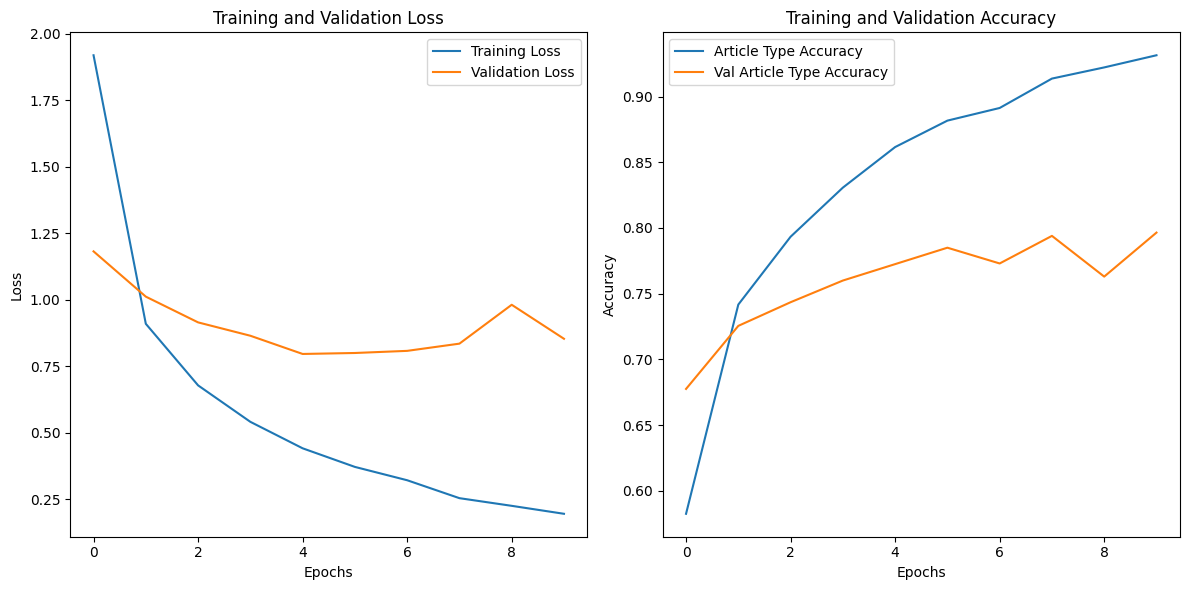

In [36]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], label='Article Type Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Article Type Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

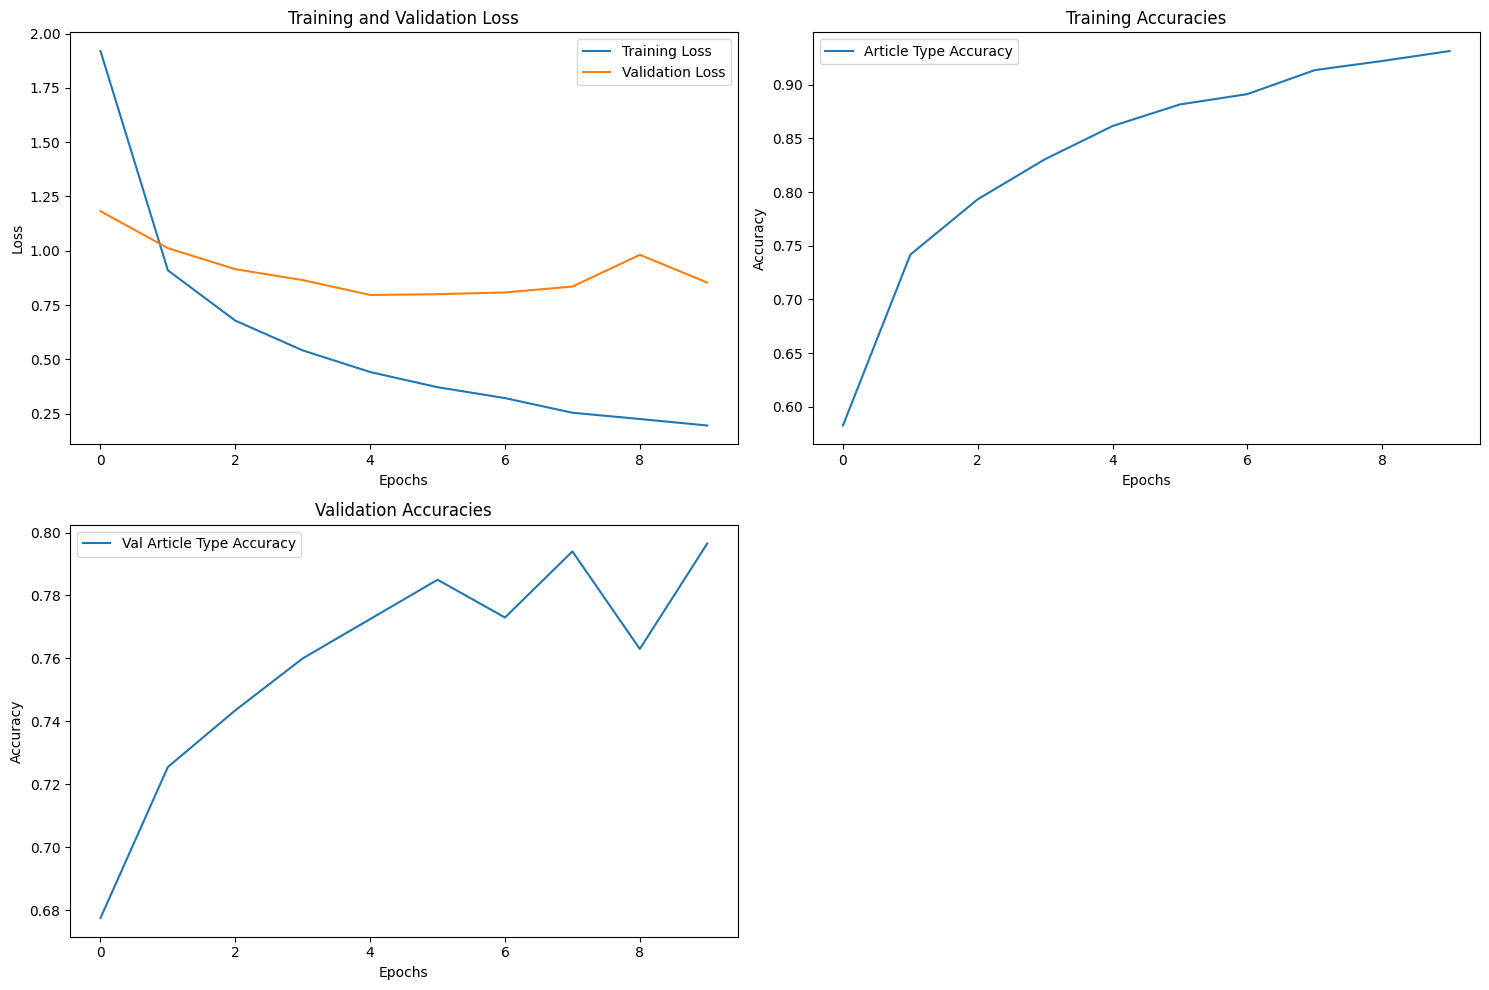

In [37]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Article Type Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Article Type Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [38]:
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Load VGG16 as the base model
base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3),
                                          include_top=False,
                                          weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Add VGG layers
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)  # Flatten the output of the base model
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a dense layer after the base model

# Output branches for multitask classification
base_colour_branch = tf.keras.layers.Dense(c_5, activation='softmax', name='baseColour_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[
    base_colour_branch
])

# Summary of the model to check the architecture
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseColour_output (Dense)       │ (None, 46)             │        23,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,933,102 (72.22 MB)

 Trainable params: 4,218,414 (16.09 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [40]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'baseColour_output': class_arr_base_colour
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.2389 - loss: 4.0947 - val_accuracy: 0.4145 - val_loss: 2.1457
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.4227 - loss: 2.0618 - val_accuracy: 0.4220 - val_loss: 2.0616
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.4782 - loss: 1.7970 - val_accuracy: 0.4605 - val_loss: 1.8809
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.5350 - loss: 1.5554 - val_accuracy: 0.4565 - val_loss: 1.9231
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.5513 - loss: 1.4655 - val_accuracy: 0.4915 - val_loss: 1.8830
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.5919 - loss: 1.3290 - val_accuracy: 0.5000 - val_loss: 1.8792
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.6119 - loss: 1.2656 - val_accuracy: 0.4930 - val_loss: 1.9514
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.6555 - loss: 1.111

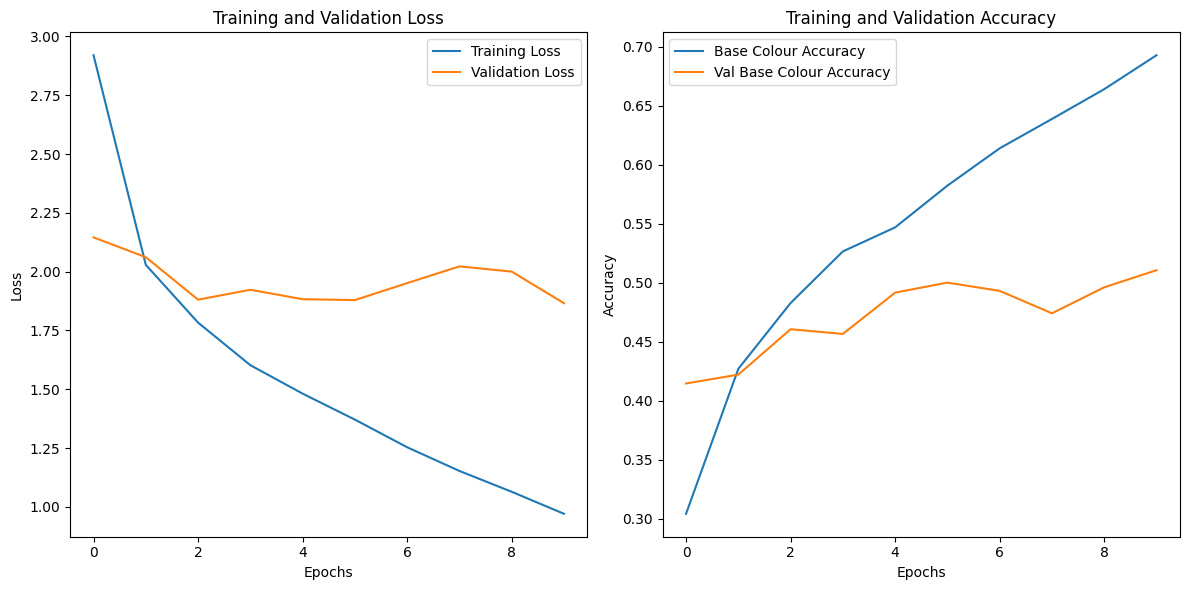

In [41]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)


plt.plot(history.history['accuracy'], label='Base Colour Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Base Colour Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

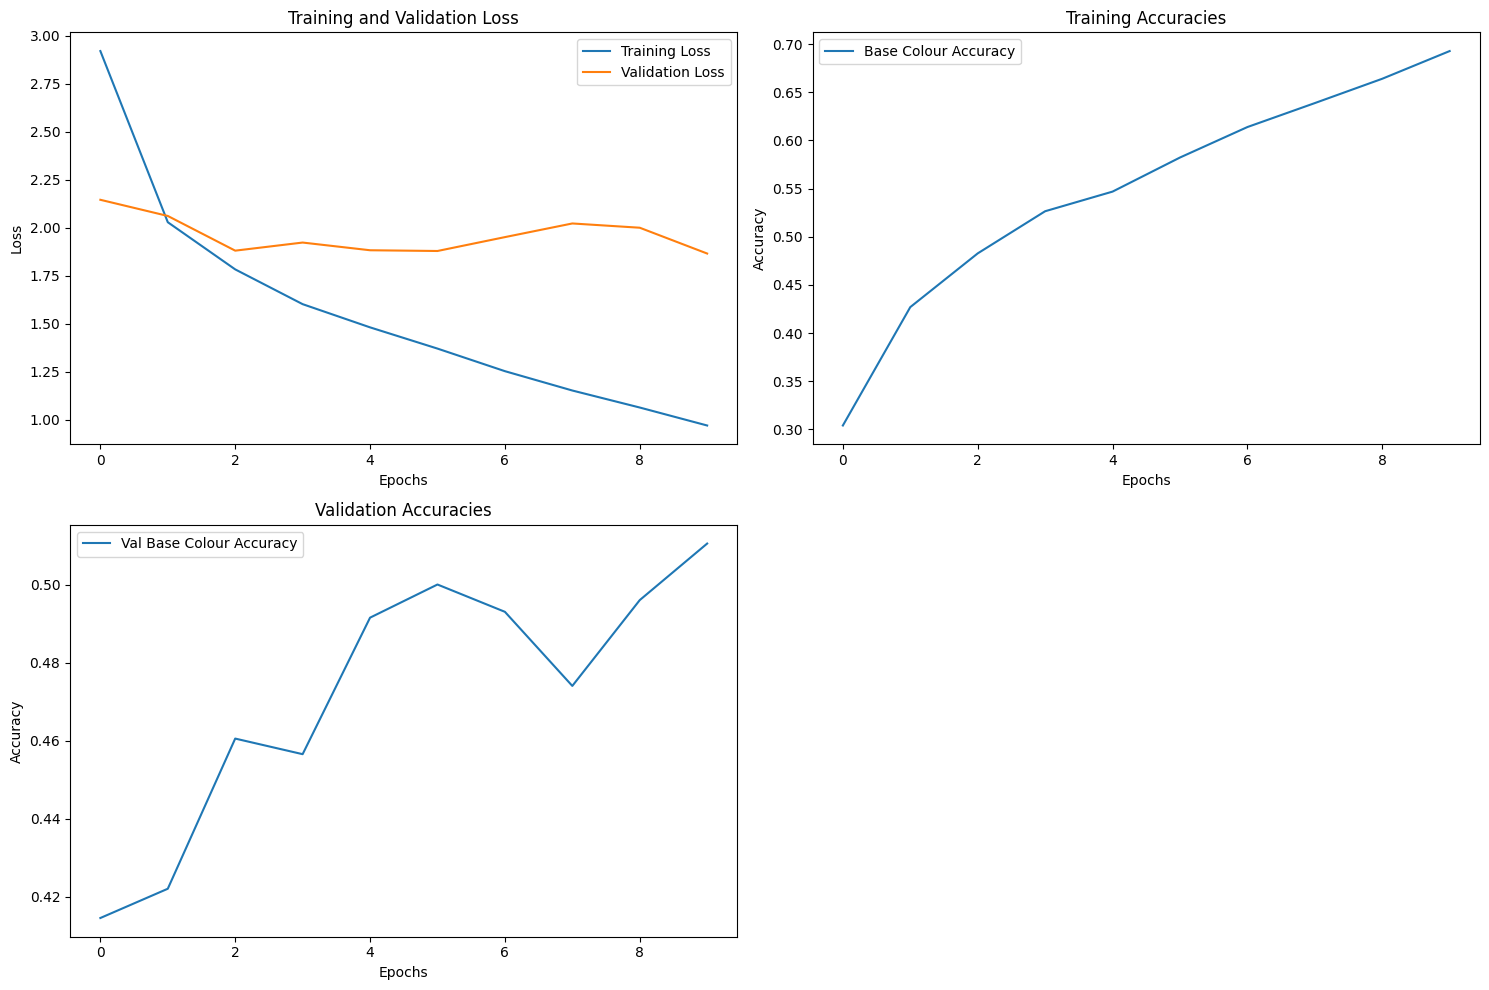

In [42]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Base Colour Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Base Colour Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

season

In [43]:
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Load VGG16 as the base model
base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3),
                                          include_top=False,
                                          weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Add VGG layers
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)  # Flatten the output of the base model
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a dense layer after the base model

# Output branches for multitask classification
season_branch = tf.keras.layers.Dense(c_6, activation='softmax', name='season_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[
    season_branch
])

# Summary of the model to check the architecture
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ season_output (Dense)           │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,912,069 (72.14 MB)

 Trainable params: 4,197,381 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [44]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [45]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'season_output': class_arr_season
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.4424 - loss: 3.6076 - val_accuracy: 0.6420 - val_loss: 0.8654
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.6103 - loss: 0.9566 - val_accuracy: 0.6145 - val_loss: 0.8623
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.6536 - loss: 0.8166 - val_accuracy: 0.6225 - val_loss: 0.8915
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.6757 - loss: 0.7418 - val_accuracy: 0.6565 - val_loss: 0.7878
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.7019 - loss: 0.6927 - val_accuracy: 0.6705 - val_loss: 0.7858
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.7088 - loss: 0.6691 - val_accuracy: 0.6655 - val_loss: 0.8673
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.7211 - loss: 0.6345 - val_accuracy: 0.6585 - val_loss: 0.7879
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.7405 - loss: 0.609

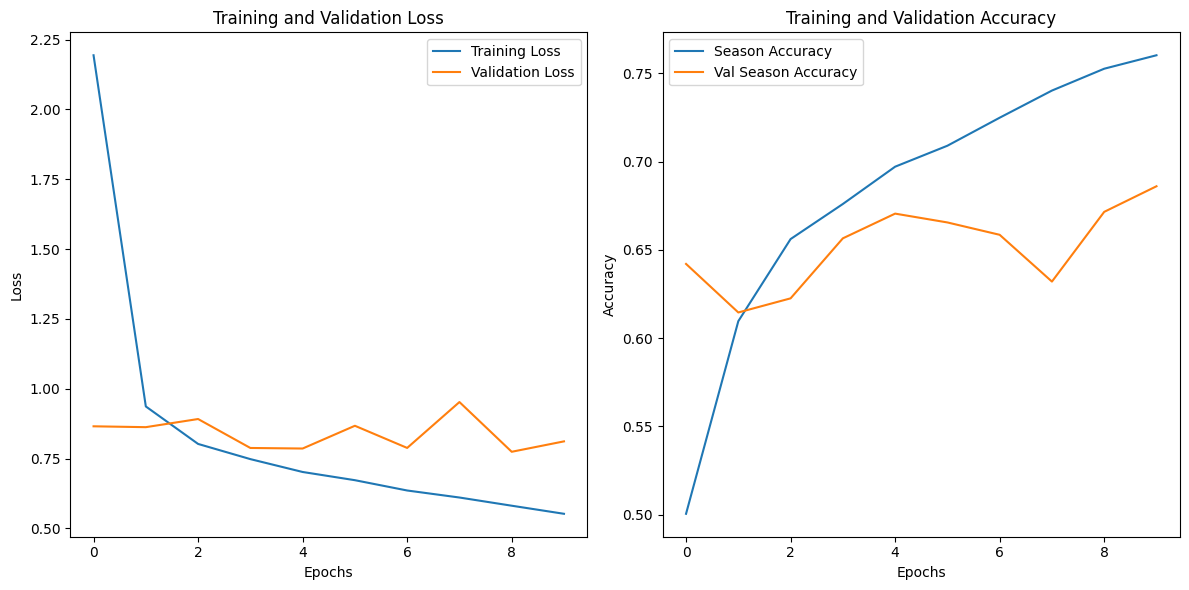

In [46]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], label='Season Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Season Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

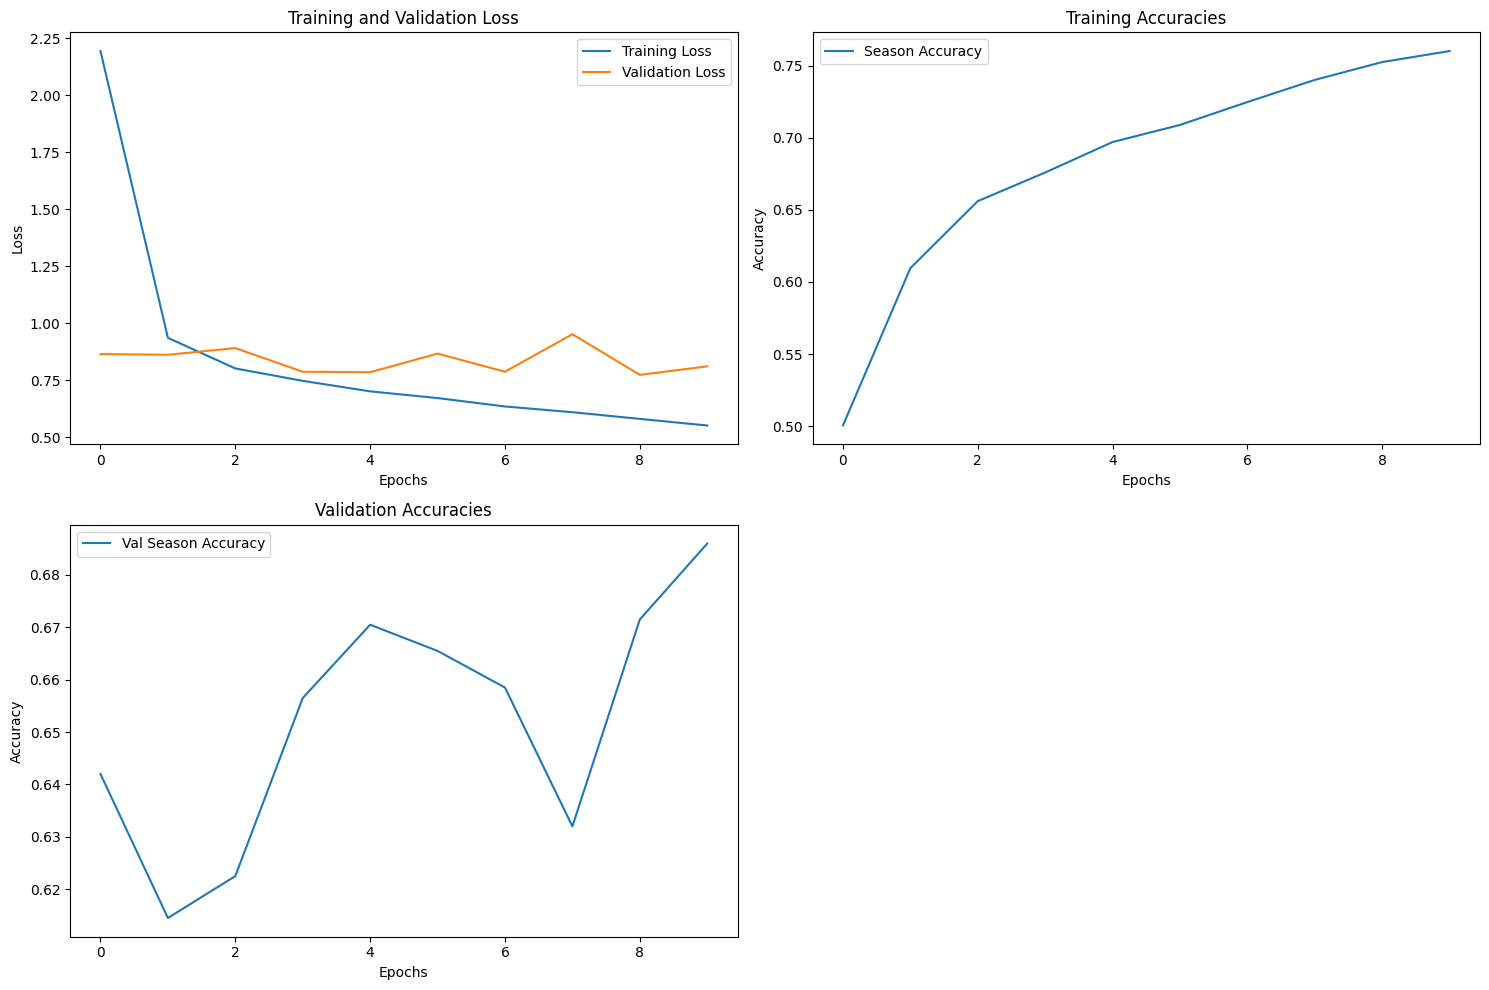

In [47]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Season Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Season Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## usage

In [9]:
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Load VGG16 as the base model
base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3),
                                          include_top=False,
                                          weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Add VGG layers
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)  # Flatten the output of the base model
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a dense layer after the base model

# Output branches for multitask classification
usage_branch = tf.keras.layers.Dense(c_7, activation='softmax', name='usage_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[
    usage_branch
])

# Summary of the model to check the architecture
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ usage_output (Dense)            │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,913,608 (72.15 MB)

 Trainable params: 4,198,920 (16.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [11]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'usage_output': class_arr_usage
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10


I0000 00:00:1729951106.123267     110 service.cc:145] XLA service 0x7a0c28004410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729951106.124203     110 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729951106.124215     110 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/125 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.3008 - loss: 4.7582  

I0000 00:00:1729951117.759118     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.7154 - loss: 1.6690 - val_accuracy: 0.8345 - val_loss: 0.5359
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.8342 - loss: 0.5003 - val_accuracy: 0.8215 - val_loss: 0.5047
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.8631 - loss: 0.3823 - val_accuracy: 0.8625 - val_loss: 0.4013
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.8882 - loss: 0.3215 - val_accuracy: 0.8665 - val_loss: 0.3993
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.9047 - loss: 0.2744 - val_accuracy: 0.8485 - val_loss: 0.4570
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.9028 - loss: 0.2572 - val_accuracy: 0.8605 - val_loss: 0.4561
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.9060 - loss: 0.2520 - val_accuracy: 0.8695 - val_loss: 0.4093
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9162 - loss: 0.2229 - val_accura

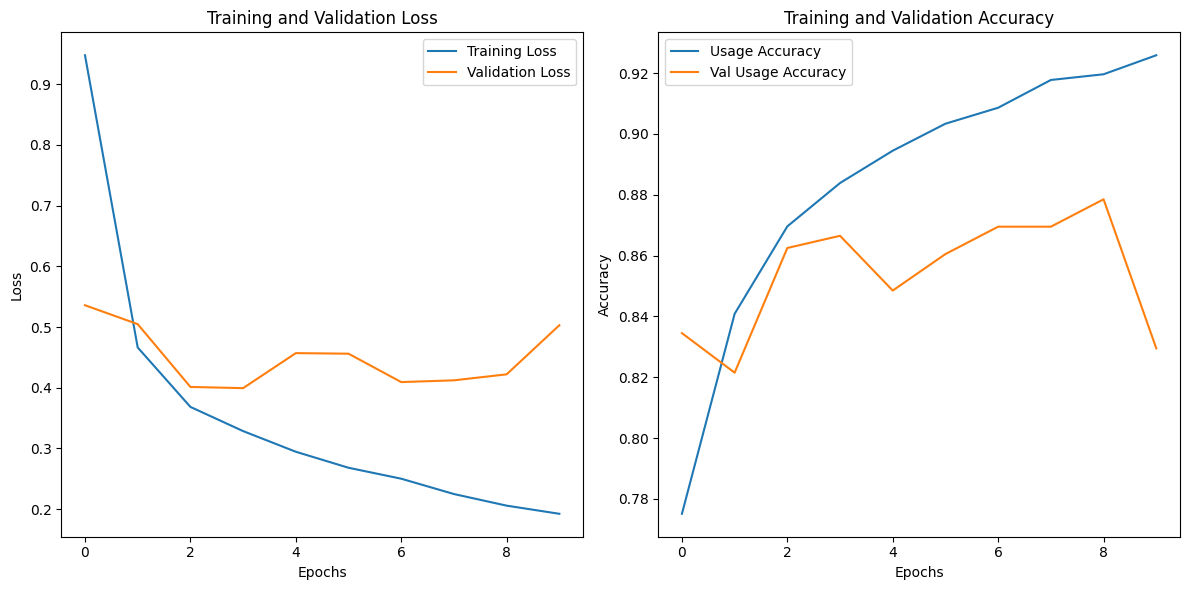

In [12]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)


plt.plot(history.history['accuracy'], label='Usage Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

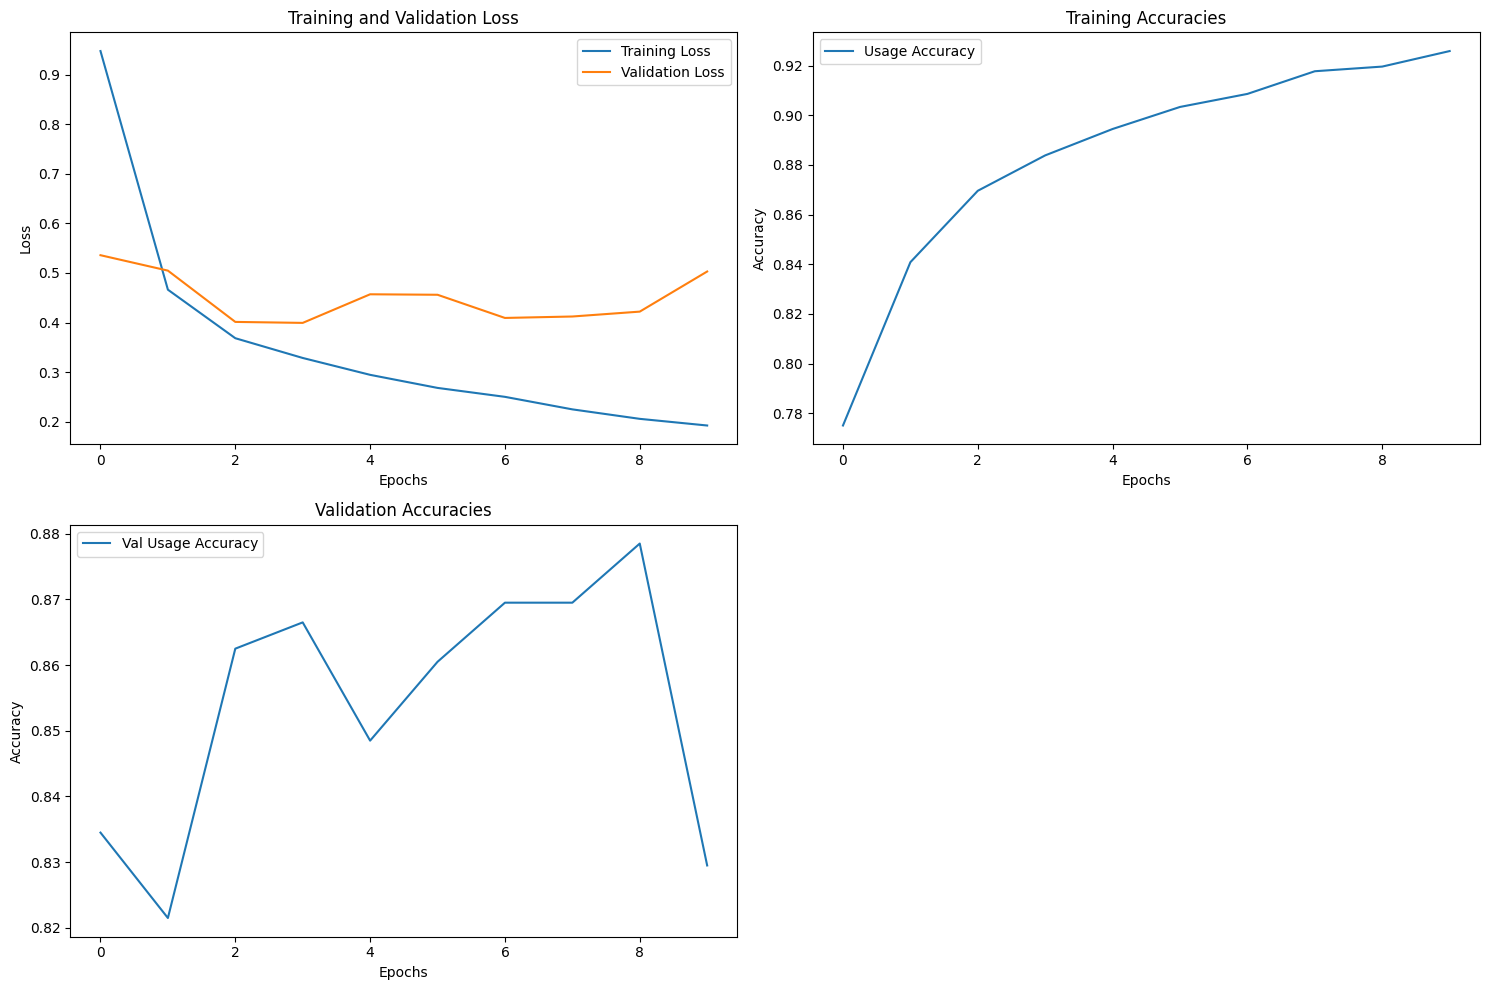

In [13]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()